In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.linalg import SparseMatrix
from pyspark.ml.linalg import SparseVector
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.sql import Row
import datetime
import numpy as np  
import matplotlib.pyplot as plt
import copy
import sys
import os
from pyspark.sql.functions import array_intersect

In [2]:
os.environ["PYSPARK_PYTHON"] = sys.executable
project_path = os.path.abspath(os.path.dirname("."))
data_path = os.path.join(project_path, "ml-32m")
java_path = "C:\\Program Files\\Java\\jdk1.8.0_202"
hadoop_path = "C:\\Program Files\\Hadoop\\hadoop-3.3.6\\bin"
os.environ["HADOOP_HOME"] = os.path.dirname(hadoop_path)
os.environ["PATH"] += os.pathsep + hadoop_path

In [3]:
spark = SparkSession.builder \
    .appName("ExampleApp") \
    .config("spark.ui.showConsoleProgress", "true") \
    .config("spark.executorEnv.JAVA_HOME", java_path) \
    .config("spark.driverEnv.JAVA_HOME", java_path) \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.resource.gpu.amount", 6) \
    .config("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.LocalFileSystem") \
    .config("spark.hadoop.fs.file.impl.disable.cache", "true") \
    .config("spark.hadoop.home.dir", hadoop_path) \
    .getOrCreate()

In [4]:
ratings = (spark.read.option("header", True)
                .csv(os.path.join(data_path, "ratings.csv")))
links = (spark.read.option("header", True)
              .csv(os.path.join(data_path, "links.csv")))
movies = (spark.read.option("header", True)
               .csv(os.path.join(data_path, "movies.csv")))
movies = movies.withColumn(
    "genres",
    F.when(F.col("movieId") == 284105, "Comedy") \
     .otherwise(F.col("genres"))
)
tags = (spark.read.option("header", True)
             .csv(os.path.join(data_path, "tags.csv")))
movies.show(1), links.show(1), ratings.show(1), tags.show(1)

+-------+----------------+--------------------+
|movieId|           title|              genres|
+-------+----------------+--------------------+
|      1|Toy Story (1995)|Adventure|Animati...|
+-------+----------------+--------------------+
only showing top 1 row

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
+-------+-------+------+
only showing top 1 row

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
+------+-------+------+---------+
only showing top 1 row

+------+-------+-----------+----------+
|userId|movieId|        tag| timestamp|
+------+-------+-----------+----------+
|    22|  26479|Kevin Kline|1583038886|
+------+-------+-----------+----------+
only showing top 1 row



(None, None, None, None)

Identification keys

id | type | present in | description
---|------|---------|------------
userId | int | ratings, tags | unique identifier for the user
movieId | int | links, movies, ratings, tags  | unique identifier for the movie
rating | float | ratings | rating given by the user to the movie
timestamp | int | ratings | timestamp of the rating
tag | str | tags | tag given by the user to the movie
title | str | movies | title of the movie
genres | str | movies | genres of the movie
imdbId | int | links | unique identifier for the movie in IMDb
tmdbId | int | links | TMDb identifier for the movie


In [5]:
ratings = (ratings.withColumn("rating", ratings["rating"].cast("float"))
                  .withColumn("userId", ratings["userId"].cast("int"))
                  .withColumn("movieId", ratings["movieId"].cast("int"))
        )
movies = movies.withColumn("movieId", movies["movieId"].cast("int"))

```python
movie_data = movies.join(links, "movieId", "outer") 
movie_data.show(5)
```


## Statistics

In [ ]:
number_of_users = ratings.select("userId").distinct().count()
number_of_movies = ratings.select("movieId").distinct().count()
number_of_ratings = ratings.count()
print("Number of ratings: ", number_of_ratings)
print("Number of users: ", number_of_users)
print("Number of movies: ", number_of_movies)

matrix_sparsity = (ratings.count() / (number_of_users * number_of_movies)) * 100
print("Matrix sparsity: ", matrix_sparsity)

print()
users_grouped = ratings.groupBy("userId")
movies_grouped = ratings.groupBy("movieId")
users_rated = users_grouped.count()
movies_rated = movies_grouped.count()
print("Average number of ratings per user: ", users_rated.agg(F.mean("count")).collect()[0][0])
print("Average number of ratings per movie: ", movies_rated.agg(F.mean("count")).collect()[0][0])
print("Mean rating:", ratings.agg(F.mean("rating")).collect()[0][0])
print("Mean rating per user:", users_grouped.agg(F.mean("rating")).agg(F.mean("avg(rating)")).collect()[0][0])
print("Mean rating per movie:", movies_grouped.agg(F.mean("rating")).agg(F.mean("avg(rating)")).collect()[0][0])    

Number of ratings:  32000204
Number of users:  200948
Number of movies:  84432
Matrix sparsity:  0.18860881306254365

Average number of ratings per user:  159.24619304496684
Average number of ratings per movie:  379.0056376729202
Mean rating: 3.5403956487277393
Mean rating per user: 3.7043683389640747
Mean rating per movie: 3.005082384974346


## Data Split

We need to observe whether the data is dependent of the time. If it is dependent, we need to split the data into training and test sets based on time. If it is not dependent, we can randomly split the data into training and test sets using `TrainValidationSplit` from the `pyspark.ml.tuning` module. We will implement this in the next steps to ensure our model is trained effectively based on the data characteristics.

In [10]:
ratings = ratings.withColumn("year", F.year(F.from_unixtime(F.col("timestamp"))))
yearly_trends = (ratings.groupBy("year")
                        .agg(
                            F.avg("rating").alias("avg_rating"), 
                            F.count("*").alias("num_ratings")
                        )
                        .orderBy("year")
                )
yearly_trends.show()

+----+------------------+-----------+
|year|        avg_rating|num_ratings|
+----+------------------+-----------+
|1995|              3.75|          4|
|1996| 3.546167818775827|    1571755|
|1997| 3.588877064986213|     685053|
|1998|3.5139587387572564|     301639|
|1999|3.6165843810879057|    1174973|
|2000|3.5765982885160987|    1912843|
|2001| 3.533412327380055|    1160425|
|2002|3.4843305279265495|     849550|
|2003|3.4744290444191424|    1010893|
|2004|3.4303692033580697|    1139345|
|2005|3.4341227737238778|    1752085|
|2006|3.4658399484224525|    1141582|
|2007|3.4704753998290805|    1023875|
|2008| 3.540532513412135|    1117831|
|2009| 3.507221597932352|     889900|
|2010| 3.534047079568612|     859736|
|2011|3.5623316781542402|     729629|
|2012|3.6088359437179807|     696066|
|2013|3.6453152802441684|     562563|
|2014|3.6117663393525197|     518564|
+----+------------------+-----------+
only showing top 20 rows



In [11]:
yearly_trends.agg(F.mean('avg_rating').alias("mean_rating"), 
                  F.median('avg_rating').alias("median_rating"), 
                  F.stddev('avg_rating').alias("std_rating"), 
                  F.max('avg_rating').alias("max_rating"), 
                  F.min('avg_rating').alias("min_rating")).show()

+------------------+-----------------+-------------------+----------+------------------+
|       mean_rating|    median_rating|         std_rating|max_rating|        min_rating|
+------------------+-----------------+-------------------+----------+------------------+
|3.5496523638495314|3.548434711534148|0.06706141615685407|      3.75|3.4303692033580697|
+------------------+-----------------+-------------------+----------+------------------+



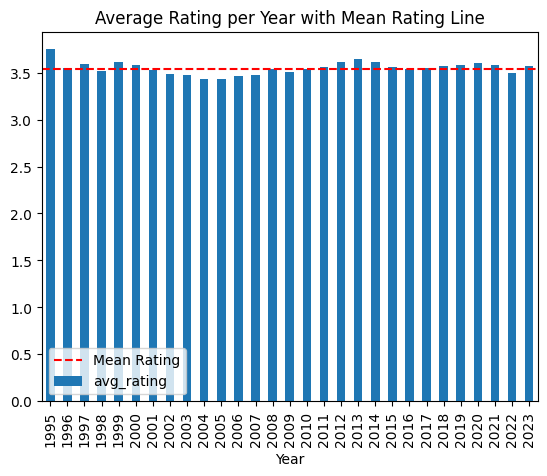

In [12]:
mean_rating = ratings.agg(F.mean("rating")).collect()[0][0]
yearly_trends.toPandas().plot(x="year", y="avg_rating", kind="bar", title="Average Rating per Year")
plt.axhline(mean_rating, color='r', linestyle='--', label='Mean Rating')
plt.xlabel("Year")
plt.legend()
plt.title("Average Rating per Year with Mean Rating Line")
plt.show()

We can observe that the data is independent of the time. Therefore, we can randomly split the data into training and test sets using `TrainValidationSplit` from the `pyspark.ml.tuning` module.

In [6]:
train_ratings, test_ratings = ratings.randomSplit([0.8, 0.2], seed=42)

## Data exploration

In [10]:
number_of_users = train_ratings.select("userId").distinct().count()
number_of_movies = train_ratings.select("movieId").distinct().count()
number_of_ratings = train_ratings.count()
print("Number of ratings: ", number_of_ratings)
print("Number of users: ", number_of_users)
print("Number of movies: ", number_of_movies)

matrix_sparsity = (train_ratings.count() / (number_of_users * number_of_movies)) * 100
print("Matrix sparsity: ", matrix_sparsity)

print()
users_grouped = train_ratings.groupBy("userId")
movies_grouped = train_ratings.groupBy("movieId")
users_rated = users_grouped.count()
movies_rated = movies_grouped.count()
print("Average number of ratings per user: ", users_rated.agg(F.mean("count")).collect()[0][0])
print("Average number of ratings per movie: ", movies_rated.agg(F.mean("count")).collect()[0][0])
print("Mean rating:", train_ratings.agg(F.mean("rating")).collect()[0][0])
print("Mean rating per user:", users_grouped.agg(F.mean("rating")).agg(F.mean("avg(rating)")).collect()[0][0])
print("Mean rating per movie:", movies_grouped.agg(F.mean("rating")).agg(F.mean("avg(rating)")).collect()[0][0])    

Number of ratings:  25600446
Number of users:  200948
Number of movies:  80185
Matrix sparsity:  0.1588805409555812

Average number of ratings per user:  127.39836176523279
Average number of ratings per movie:  319.26726943942134
Mean rating: 3.5403927142519316
Mean rating per user: 3.7044770806023575
Mean rating per movie: 3.015131601139284


Matrix is sparse enough for collaborative filtering.

<Axes: xlabel='rating'>

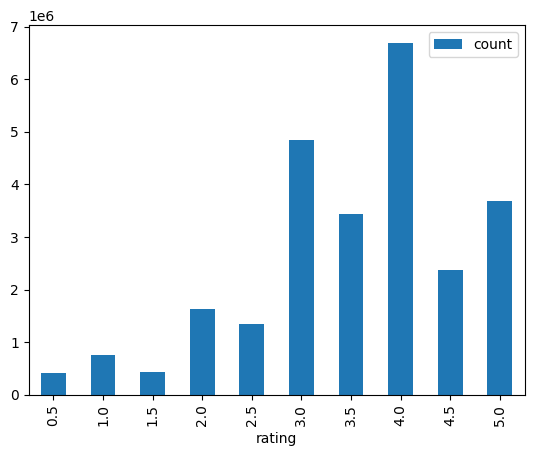

In [11]:
ratings_distribution = train_ratings.groupBy("rating").count().toPandas().sort_values("rating")
ratings_distribution.plot(x="rating", y="count", kind="bar")

Here, we can observe that the ratings have a skewed distribution, with most ratings being 3 or 4 stars. In this case, we can use the `median` as a measure of central tendency.



In [12]:
user_count = users_grouped.count()
user_count_df = user_count.toPandas()

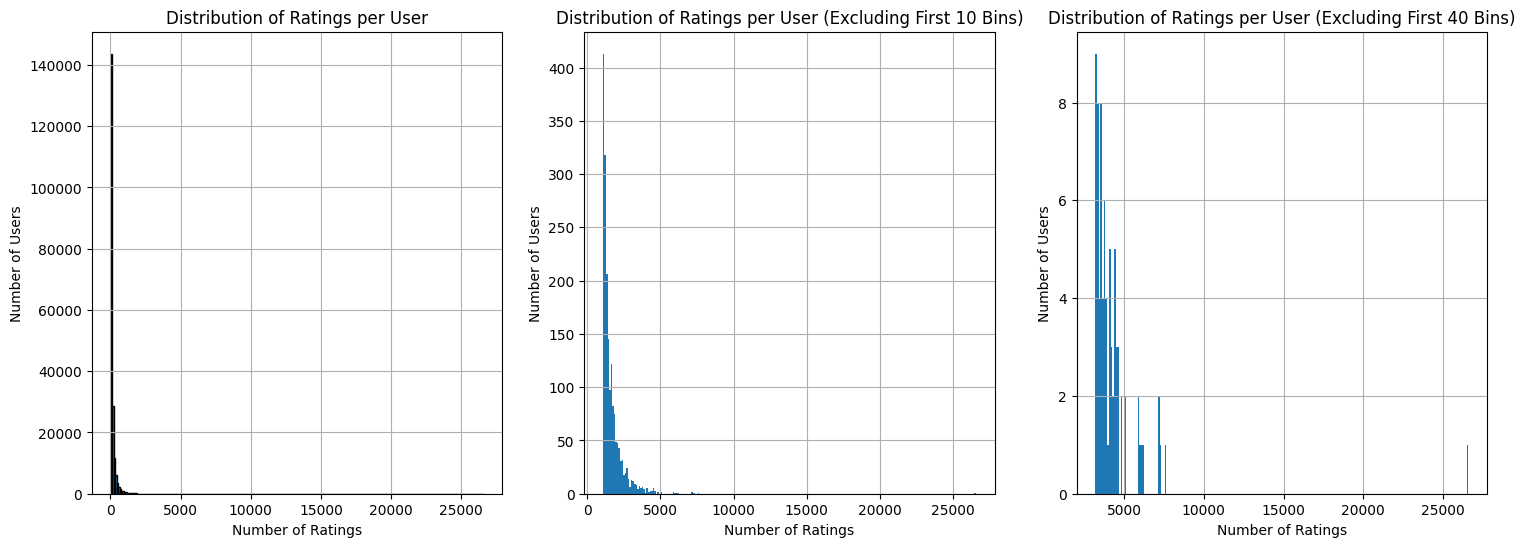

In [13]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
user_count_df["count"].hist(bins=250, edgecolor="black")
plt.title("Distribution of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")


plt.subplot(1, 3, 2)
# Determine the bin edges
bin_edges = user_count_df["count"].quantile([i / 250 for i in range(200)])  # First 10 bins

# Filter out data within the first 10 bins
bin_size = (user_count_df['count'].max() - user_count_df['count'].min()) / 250 
filtered_user_count_df = user_count_df[user_count_df["count"] > bin_size * 10]

# Plot the histogram
filtered_user_count_df["count"].hist(bins=240)  # Adjust bins accordingly
plt.title("Distribution of Ratings per User (Excluding First 10 Bins)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")

plt.subplot(1, 3, 3)
# Filter out data within the first 40 bins
bin_size = (user_count_df['count'].max() - user_count_df['count'].min()) / 250 
filtered_user_count_df = user_count_df[user_count_df["count"] > bin_size * 30]

# Plot the histogram
filtered_user_count_df["count"].hist(bins=220)  # Adjust bins accordingly
plt.title("Distribution of Ratings per User (Excluding First 40 Bins)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

Many users have rated only a few movies, and many movies have been rated by only a few users.

In [12]:
movies_count = movies_grouped.count()
movies_count_df = movies_count.toPandas()

ImportError: Pandas >= 1.0.5 must be installed; however, it was not found.

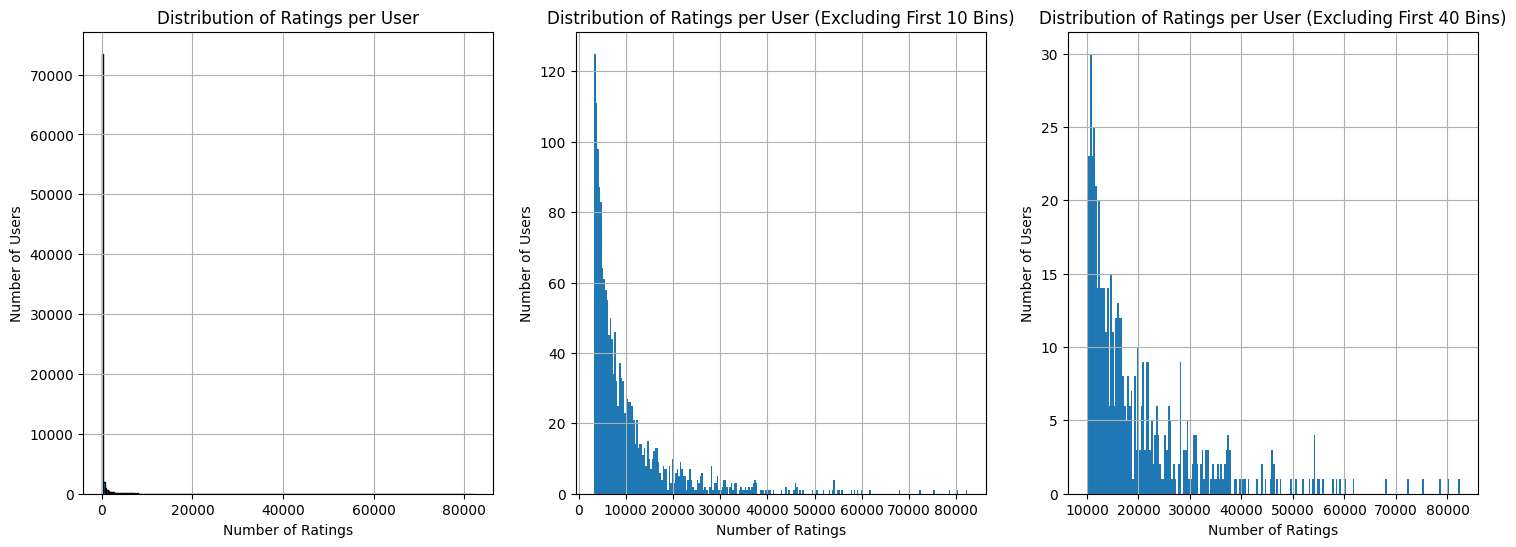

In [15]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
movies_count_df["count"].hist(bins=250, edgecolor="black")
plt.title("Distribution of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")


plt.subplot(1, 3, 2)
# Determine the bin edges
bin_edges = movies_count_df["count"].quantile([i / 250 for i in range(200)])  # First 10 bins

# Filter out data within the first 10 bins
bin_size = (movies_count_df['count'].max() - movies_count_df['count'].min()) / 250 
filtered_movies_count_df = movies_count_df[movies_count_df["count"] > bin_size * 10]

# Plot the histogram
filtered_movies_count_df["count"].hist(bins=240)  # Adjust bins accordingly
plt.title("Distribution of Ratings per User (Excluding First 10 Bins)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")

plt.subplot(1, 3, 3)
# Filter out data within the first 40 bins
bin_size = (movies_count_df['count'].max() - movies_count_df['count'].min()) / 250 
filtered_movies_count_df = movies_count_df[movies_count_df["count"] > bin_size * 30]

# Plot the histogram
filtered_movies_count_df["count"].hist(bins=220)  # Adjust bins accordingly
plt.title("Distribution of Ratings per User (Excluding First 40 Bins)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

Long tail: We can observe that movies which are frequently rated by users are few in number. This is a good sign for neighbourhood-based collaborative filtering.

In many cases, ratings of these high frequency movies are not representative of the ratings of low-frequency movies. because of the inherent differences in raing patterns of the 2 classes of items. As a result, prediction process may yield misleading results.

If we provide commonly rated movies as input to the model, it may not be able to learn the rating patterns of low-frequency movies. This is because the model will be biased towards the rating patterns of high-frequency movies and the user may not be able to get the desired recommendations.

Therefore, we can utilize the notion of `Inverse User Frequency` to address this issue. This will help us to balance the rating patterns of high-frequency and low-frequency movies. 

For each movie $j$ with ratings $m_j$ and total number of ratings $m$, we can calculate the inverse user frequency as follows: 
$$w_j = \log \bigg(\frac{m}{m_j}\bigg)$$

In [13]:
movie_weights = movies_count.withColumn(
    "weight", F.log(number_of_ratings / F.col("count")))
(movie_weights.join(movies, "movieId")
              .orderBy("weight", ascending=False)
              .show(10))

+-------+-----+------------------+--------------------+------------------+
|movieId|count|            weight|               title|            genres|
+-------+-----+------------------+--------------------+------------------+
| 183467|    1|17.058120331173033|Treasure Hounds (...|  Children|Fantasy|
| 215975|    1|17.058120331173033| Schmeerguntz (1965)|            Comedy|
| 263885|    1|17.058120331173033|The Cinderella Ad...|       Crime|Drama|
| 235629|    1|17.058120331173033|  At Sundance (1995)|       Documentary|
| 267474|    1|17.058120331173033|   The Lodger (1967)|            Comedy|
| 138354|    1|17.058120331173033|Scattered Cloud (...|(no genres listed)|
| 146118|    1|17.058120331173033|       Benaam (1974)|(no genres listed)|
| 139155|    1|17.058120331173033|Un fidanzato per ...|            Comedy|
| 225699|    1|17.058120331173033|         Aura (2018)|            Horror|
| 272891|    1|17.058120331173033|The Other Woman (...|             Drama|
+-------+-----+----------

In [ ]:
# sum_of_weights = movie_weights.agg(F.sum("weight")).collect()[0][0]
# movie_weights_normalized = movie_weights.withColumn(
#     "weight", F.col("weight") / sum_of_weights
# )

NameError: name 'movie_weights' is not defined

## Metrics

We will use the following metrics to evaluate the model:
- RMSE: Root Mean Squared Error - Robustness of prediction across the range of ratings. Problem with it is it is sensitive to outliers, which can skew the results and lead to misleading conclusions. RMSE is not a true reflection of the average error.
- MAE: Mean Absolute Error - Better reflection of the accuracy when the importance of outliers is not high

Prediction of accuracies on sparse items is different from prediction of accuracies on dense items. So, to handle this, compute RMSE or MAE separately for all hidden ratings associated with each item and average over the different items in a weighted fashion. This is called weighted RMSE or weighted MAE.

## Baseline models
We will use a simple baseline model to predict the ratings. The model will be based on the average rating of each movie. This is a simple model that can be used as a baseline for more complex models. We will use the average rating of each movie as the predicted rating for that movie. This model is simple and easy to implement, but it can be improved by using more complex models such as collaborative filtering or content-based filtering.

In [ ]:
top_movies = (train_ratings
              .groupBy("movieId")
              .agg(F.avg("rating").alias("avg_rating"))
              .orderBy(F.desc("avg_rating"))
              .limit(10))

```
+-------+----------+
|movieId|avg_rating|
+-------+----------+
| 136998|       5.0|
| 137038|       5.0|
| 136988|       5.0|
| 200312|       5.0|
| 209821|       5.0|
| 137050|       5.0|
| 185241|       5.0|
| 135350|       5.0|
| 124893|       5.0|
| 206721|       5.0|
+-------+----------+
only showing top 10 rows
```

Explicit feedback implies that the user has rated the movie. 


Implicit feedback implies that the user has watched the movie but they did not rate. Since we do not have information about the user watching the movie, we will not be able to use implicit feedback. We will only use explicit feedback for the model. 


In [ ]:
explicit_baseline = train_ratings.join(
    top_movies, train_ratings.movieId == top_movies.movieId,
)
evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="avg_rating", metricName="rmse"
)
explicit_rmse = evaluator.evaluate(explicit_baseline)
print("Explicit RMSE: ", explicit_rmse)

Explicit RMSE:  2.0089087300607473


```python
test_users = test_movie_ratings.select("userId").distinct().select("userId")
users_top_movies = test_users.join(top_movies)
implicit_baseline = users_top_movies.join(
    test_movie_ratings, ["userId", "movieId"], "left"
).select(
    users_top_movies.userId, 
    users_top_movies.movieId,
    F.when(F.col("rating").isNull(), 0).otherwise(F.col("rating")).alias("rating"),   
    users_top_movies.avg_rating
)
implicit_rmse = evaluator.evaluate(implicit_baseline)
print("Implicit RMSE: ", implicit_rmse)
```

### Average rating


In [17]:
average_movie_rating = (train_ratings
              .groupBy("movieId")
              .agg(F.avg("rating").alias("avg_rating"))
              .orderBy(F.desc("avg_rating"))
              ).select("movieId", "avg_rating")

average_baseline = test_ratings.join(
    average_movie_rating, "movieId", "left"
).select(
    test_ratings.userId, 
    test_ratings.movieId,
    test_ratings.rating,
    F.when(F.col("avg_rating").isNull(), 0).otherwise(F.col("avg_rating")).alias("avg_rating")
)
rmse_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="avg_rating", metricName="rmse"
)
average_rmse = rmse_evaluator.evaluate(average_baseline)
mae_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="avg_rating", metricName="mae"
)
average_mae = mae_evaluator.evaluate(average_baseline)
print("RMSE:", average_rmse)
print("MAE:", average_mae)

RMSE: 0.963402602485829
MAE: 0.7422687164034186


In [28]:
# Step 1: Join weights
average_baseline_with_weights = average_baseline.join(
    movie_weights, "movieId", "left"
).select(
    average_baseline.userId, 
    average_baseline.movieId,
    average_baseline.rating,
    average_baseline.avg_rating,
    F.when(F.col("weight").isNull(), 0).otherwise(F.col("weight")).alias("weight")
)

# Step 2: Calculate absolute error
mae_predictions = average_baseline_with_weights.withColumn(
    "absolute_error", F.abs(F.col("rating") - F.col("avg_rating"))
)
rmse_predictions = average_baseline_with_weights.withColumn(
    "squared_error", F.pow(F.col("rating") - F.col("avg_rating"), 2)
)

# Step 3: Multiply absolute error by weight
mae_predictions = mae_predictions.withColumn(
    "weighted_error", F.col("absolute_error") * F.col("weight")
)
rmse_predictions = rmse_predictions.withColumn(
    "weighted_squared_error", F.col("squared_error") * F.col("weight")
)

# Step 4: Calculate Weighted MAE
weighted_rmse = rmse_predictions.agg(
    F.sqrt((F.sum("weighted_squared_error") / F.sum("weight"))).alias("weighted_rmse")
).collect()[0]["weighted_rmse"]
weighted_mae = mae_predictions.agg(
    (F.sum("weighted_error") / F.sum("weight")).alias("weighted_mae")
).collect()[0]["weighted_mae"]

print("Weighted RMSE:", weighted_rmse)
print("Weighted MAE:", weighted_mae)

Weighted RMSE: 0.9667046754972082
Weighted MAE: 0.7460749507679142


### Median rating

Since ratings are skewed, I expect the median rating to provide a more accurate reflection of user preferences. We will use median rating as the baseline for the model. This is a simple model that can be used as a baseline for more complex models. We will use the median rating of each movie as the predicted rating for that movie. This model is simple and easy to implement, but it can be improved by using more complex models such as collaborative filtering or content-based filtering.


In [7]:
median_movie_rating = (train_ratings
              .groupBy("movieId")
              .agg(F.median("rating").alias("median_rating"))
              .orderBy(F.desc("median_rating"))
              ).select("movieId", "median_rating")

median_baseline = test_ratings.join(
    median_movie_rating, "movieId", "left"
).select(
    test_ratings.userId, 
    test_ratings.movieId,
    test_ratings.rating,
    F.when(F.col("median_rating").isNull(), 0).otherwise(F.col("median_rating")).alias("median_rating")
)
rmse_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="median_rating", metricName="rmse"
)
median_rmse = rmse_evaluator.evaluate(median_baseline)
mae_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="median_rating", metricName="mae"
)
median_mae = mae_evaluator.evaluate(median_baseline)
print("RMSE:", median_rmse)
print("MAE:", median_mae)

RMSE: 0.9845125250844892
MAE: 0.7224906004258286


In [16]:
# Step 1: Join weights
median_baseline_with_weights = median_baseline.join(
    movie_weights, "movieId", "left"
).select(
    median_baseline.userId, 
    median_baseline.movieId,
    median_baseline.rating,
    median_baseline.median_rating,
    F.when(F.col("weight").isNull(), 0).otherwise(F.col("weight")).alias("weight")
)

# Step 2: Calculate absolute error
mae_predictions = median_baseline_with_weights.withColumn(
    "absolute_error", F.abs(F.col("rating") - F.col("median_rating"))
)
rmse_predictions = median_baseline_with_weights.withColumn(
    "squared_error", F.pow(F.col("rating") - F.col("median_rating"), 2)
)

# Step 3: Multiply absolute error by weight
mae_predictions = mae_predictions.withColumn(
    "weighted_error", F.col("absolute_error") * F.col("weight")
)
rmse_predictions = rmse_predictions.withColumn(
    "weighted_squared_error", F.col("squared_error") * F.col("weight")
)

# Step 4: Calculate Weighted MAE
weighted_rmse = rmse_predictions.agg(
    F.sqrt((F.sum("weighted_squared_error") / F.sum("weight"))).alias("weighted_rmse")
).collect()[0]["weighted_rmse"]
weighted_mae = mae_predictions.agg(
    (F.sum("weighted_error") / F.sum("weight")).alias("weighted_mae")
).collect()[0]["weighted_mae"]

print("Weighted RMSE:", weighted_rmse)
print("Weighted MAE:", weighted_mae)

Weighted RMSE: 0.9879927932541871
Weighted MAE: 0.7264651013046145


### KNN

We can use User-based collaborative filtering to predict the ratings for the movies. We will use the following measures to compute the similarity between users:
- Pearson coefficient (Mean-centered rating): Subtracting the mean from the ratings of each user and then computing the correlation between the ratings of the two users. This is a good measure of similarity between users.
- Z score (Normalized rating): Subtracting the mean from the ratings of each user and then dividing by the standard deviation of the ratings of that user. This is a good measure of similarity between users when the ratings are not normally distributed.
- Cosine similarity: Computing the cosine of the angle between the ratings of the two users. This is a good measure of similarity between users when the ratings are not normally distributed. I believe this is not the best measure because some users provide very high ratings and some users provide very low ratings. This can skew the results and lead to misleading conclusions.
- Weighted Pearson coefficient: Impact of long tail is huge. So, we will use weighted Pearson coefficient to compute the similarity between users. This is a good measure of similarity between users when the ratings are not normally distributed. We will use this measure to compute the similarity between users and then use the similarity to predict the ratings for the movies.

We can use Movie-based collaborative filtering to predict the ratings for the movies. We will use the following measures to compute the similarity between movies:
- Adjusted cosine similarity: Subtracting the mean from the ratings of each movie and then computing the correlation between the ratings of the two movies. This is a good measure of similarity between movies.
- Pearson coefficient (Mean-centered rating): Subtracting the mean from the ratings of each movie and then computing the correlation between the ratings of the two movies. This is a good measure of similarity between movies. But adjusted cosine similarity is better than this measure.

Movie-based collaborative filtering is better than user-based collaborative filtering because there are many users who have rated only a few movies and many movies which have been rated by only a few users and a new movie can be suggested if the movie is similar to the movies that the user has already rated. This is not possible with user-based collaborative filtering because there are many users who have rated only a few movies and many movies which have been rated by only a few users. So, we will use movie-based collaborative filtering to predict the ratings for the movies.

In [46]:
movies_onehot = movies.withColumn("genres", F.lower(F.col("genres")))
movies_onehot = movies_onehot.withColumn("genres", F.explode(F.split(F.col("genres"), "\\|")))
movies_onehot = movies_onehot.groupBy("movieId").pivot("genres").count().fillna(0)
movies_onehot.show(3)

+-------+------------------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+----+-------+-------+-------+------+--------+---+-------+
|movieId|(no genres listed)|action|adventure|animation|children|comedy|crime|documentary|drama|fantasy|film-noir|horror|imax|musical|mystery|romance|sci-fi|thriller|war|western|
+-------+------------------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+----+-------+-------+-------+------+--------+---+-------+
| 147414|                 0|     1|        0|        0|       0|     0|    0|          0|    1|      0|        0|     0|   0|      0|      0|      1|     0|       1|  0|      0|
| 151859|                 0|     0|        1|        0|       0|     0|    1|          0|    0|      0|        0|     0|   0|      0|      1|      0|     0|       0|  0|      0|
| 198607|                 0|     0|        0|        1|       0|     1|    0|          0|    0|      0|       

In [7]:
movies_onehot = movies.withColumn("genres", F.lower(F.col("genres")))
movies_onehot = movies_onehot.withColumn("genres", F.explode(F.split(F.col("genres"), "\\|")))
movies_onehot = movies_onehot.groupBy("movieId").pivot("genres").count()

In [12]:
# Get length and width of the matrix
num_rows = movies_onehot.count()
num_cols = len(movies_onehot.columns) - 1  # Exclude the 'movieId' column

In [17]:
movies_single = movies.withColumn("genres", F.lower(F.col("genres")))
movies_single = movies_single.withColumn("genres", F.explode(F.split(F.col("genres"), "\\|")))


In [20]:
movies_single.select("genres").rdd.flatMap(lambda x: x).collect()

['adventure',
 'animation',
 'children',
 'comedy',
 'fantasy',
 'adventure',
 'children',
 'fantasy',
 'comedy',
 'romance',
 'comedy',
 'drama',
 'romance',
 'comedy',
 'action',
 'crime',
 'thriller',
 'comedy',
 'romance',
 'adventure',
 'children',
 'action',
 'action',
 'adventure',
 'thriller',
 'comedy',
 'drama',
 'romance',
 'comedy',
 'horror',
 'adventure',
 'animation',
 'children',
 'drama',
 'action',
 'adventure',
 'romance',
 'crime',
 'drama',
 'drama',
 'romance',
 'comedy',
 'comedy',
 'action',
 'comedy',
 'crime',
 'drama',
 'thriller',
 'comedy',
 'crime',
 'thriller',
 'crime',
 'drama',
 'horror',
 'mystery',
 'thriller',
 'action',
 'crime',
 'thriller',
 'drama',
 'sci-fi',
 'drama',
 'romance',
 'drama',
 'children',
 'drama',
 'drama',
 'romance',
 'adventure',
 'drama',
 'fantasy',
 'mystery',
 'sci-fi',
 'crime',
 'drama',
 'drama',
 'mystery',
 'sci-fi',
 'thriller',
 'adventure',
 'romance',
 'imax',
 'children',
 'drama',
 'drama',
 'romance',
 'crime'

In [10]:
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.linalg.distributed import RowMatrix
import numpy

# Example: Create an RDD of SparseVectors
data = [
    SparseVector(5, {0: 1.0, 3: 2.0}),
    SparseVector(5, {1: 3.0}),
    SparseVector(5, {2: 4.0, 4: 5.0})
]
rdd = spark.sparkContext.parallelize(data)

# Create a RowMatrix
row_matrix = RowMatrix(rdd)

# Print the number of rows and columns
print("Number of rows:", row_matrix.numRows())
print("Number of columns:", row_matrix.numCols())

Py4JJavaError: An error occurred while calling o158.numRows.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 17 in stage 17.0 failed 1 times, most recent failure: Lost task 17.0 in stage 17.0 (TID 57) (10.173.0.254 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Program Files\spark\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 1227, in main
  File "C:\Program Files\spark\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 90, in read_command
  File "C:\Program Files\spark\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\serializers.py", line 174, in _read_with_length
    return self.loads(obj)
           ^^^^^^^^^^^^^^^
  File "C:\Program Files\spark\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\serializers.py", line 472, in loads
    return cloudpickle.loads(obj, encoding=encoding)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\spark\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\mllib\__init__.py", line 26, in <module>
    import numpy
ModuleNotFoundError: No module named 'numpy'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at org.apache.spark.util.Iterators$.size(Iterators.scala:29)
	at org.apache.spark.util.Utils$.getIteratorSize(Utils.scala:1787)
	at org.apache.spark.rdd.RDD.$anonfun$count$1(RDD.scala:1296)
	at org.apache.spark.rdd.RDD.$anonfun$count$1$adapted(RDD.scala:1296)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1296)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.numRows(RowMatrix.scala:76)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Program Files\spark\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 1227, in main
  File "C:\Program Files\spark\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 90, in read_command
  File "C:\Program Files\spark\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\serializers.py", line 174, in _read_with_length
    return self.loads(obj)
           ^^^^^^^^^^^^^^^
  File "C:\Program Files\spark\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\serializers.py", line 472, in loads
    return cloudpickle.loads(obj, encoding=encoding)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\spark\spark-3.5.5-bin-hadoop3\python\lib\pyspark.zip\pyspark\mllib\__init__.py", line 26, in <module>
    import numpy
ModuleNotFoundError: No module named 'numpy'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at org.apache.spark.util.Iterators$.size(Iterators.scala:29)
	at org.apache.spark.util.Utils$.getIteratorSize(Utils.scala:1787)
	at org.apache.spark.rdd.RDD.$anonfun$count$1(RDD.scala:1296)
	at org.apache.spark.rdd.RDD.$anonfun$count$1$adapted(RDD.scala:1296)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
sparse_vector = SparseVector(num_cols, movies_single.select("genres").rdd.flatMap(lambda x: x).collect())

In [18]:
movies_single.show(3)

+-------+----------------+---------+
|movieId|           title|   genres|
+-------+----------------+---------+
|      1|Toy Story (1995)|adventure|
|      1|Toy Story (1995)|animation|
|      1|Toy Story (1995)| children|
+-------+----------------+---------+
only showing top 3 rows



In [13]:
movies_sparse = SparseMatrix(
    numCols=num_cols,
    numRows=num_rows,
    ).asML(movies_onehot)

TypeError: SparseMatrix.__init__() missing 3 required positional arguments: 'colPtrs', 'rowIndices', and 'values'

In [52]:
movie_feature_cols = movies_onehot.columns[1:]
movies_assembler = VectorAssembler(inputCols=movie_feature_cols, outputCol="features")
movies_onehot = movies_assembler.transform(movies_onehot).select("movieId", "features")
movies_onehot.show(3)

+-------+--------------------+
|movieId|            features|
+-------+--------------------+
| 147414|(20,[1,8,15,17],[...|
| 151859|(20,[2,6,14],[1.0...|
| 198607|(20,[3,5],[1.0,1.0])|
+-------+--------------------+
only showing top 3 rows



In [66]:
kmeans_k_silhouette = []
for k in range(4, 102, 4):
    kmeans  = KMeans(k=k, seed=1, featuresCol="features", predictionCol="cluster")
    kmeans_model = kmeans.fit(movies_onehot)
    kmeans_predictions = kmeans_model.transform(movies_onehot)
    kmeans_evaluator = ClusteringEvaluator(predictionCol="cluster", featuresCol="features")
    kmeans_silhouette = kmeans_evaluator.evaluate(kmeans_predictions)
    kmeans_k_silhouette.append(kmeans_silhouette)
    print("KMeans Silhouette for k={}: ".format(k), kmeans_silhouette)

KMeans Silhouette for k=4:  0.230810648300273
KMeans Silhouette for k=8:  0.39686344953318026
KMeans Silhouette for k=12:  0.4848765551460012
KMeans Silhouette for k=16:  0.5319577537939459
KMeans Silhouette for k=20:  0.5318168525599805
KMeans Silhouette for k=24:  0.5415442583274652
KMeans Silhouette for k=28:  0.5849899949393773
KMeans Silhouette for k=32:  0.5571072623394723
KMeans Silhouette for k=36:  0.5607506883778433
KMeans Silhouette for k=40:  0.614128636474643
KMeans Silhouette for k=44:  0.6331749824121705
KMeans Silhouette for k=48:  0.6253644539181423
KMeans Silhouette for k=52:  0.6611498467531288
KMeans Silhouette for k=56:  0.6633362494386746
KMeans Silhouette for k=60:  0.6703229654234004
KMeans Silhouette for k=64:  0.6848288955160527
KMeans Silhouette for k=68:  0.6925814677360485
KMeans Silhouette for k=72:  0.6865237035747763
KMeans Silhouette for k=76:  0.7078725859269042
KMeans Silhouette for k=80:  0.7142984774761176
KMeans Silhouette for k=84:  0.713118810151

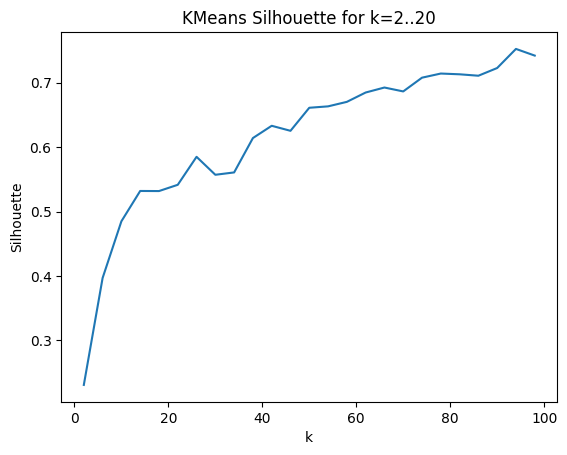

In [68]:
plt.plot(range(2, 102, 4), kmeans_k_silhouette)
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("KMeans Silhouette for k=2..20")
plt.show()

In [ ]:
kmeans_evaluator.

In [6]:
# Set the maximum number of columns allowed in a pivot operation
spark.conf.set("spark.sql.pivotMaxValues", 60000)

# Pivot the table to create a column for each movieId
pivot_df = train_movie_ratings.groupBy("userId").pivot("movieId").agg(F.first("rating"))


In [9]:
# Fill missing values with 0
filled_df = pivot_df.fillna(0)

: 

: 

In [8]:
# Set the maximum number of columns allowed in a pivot operation
spark.conf.set("spark.sql.pivotMaxValues", 60000)

all_users = train_movie_ratings.select("userId").distinct().select("userId")    
all_movies = train_movie_ratings.select("movieId").distinct().select("movieId")     

all_users_movies = all_users.crossJoin(all_movies)
all_users_movies_ratings = all_users_movies.join(
    train_movie_ratings, ["userId", "movieId"], "left"
).select(
    all_users_movies.userId, 
    all_users_movies.movieId,
    F.when(F.col("rating").isNull(), 0).otherwise(F.col("rating")).alias("rating")
)

# Pivot the table to create a column for each movieId
pivot_df = all_users_movies_ratings.groupBy("userId").pivot("movieId").agg(F.first("rating"))

In [ ]:
# Step 3: Convert rows to vectors
movie_columns = pivot_df.columns[1:]  # Exclude userId
vector_assembler = VectorAssembler(inputCols=movie_columns, outputCol="features")
vectorized_df = vector_assembler.transform(pivot_df).select("userId", "features")

# Step 4: Apply KMeans for clustering (or use similarity for KNN)
kmeans = KMeans(k=10, seed=42, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(vectorized_df)

# Step 5: Get cluster assignments
clustered_df = kmeans_model.transform(vectorized_df)


## ALS

In [7]:
als_model = ALS(
    maxIter=5,
    regParam=0.01,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    implicitPrefs=False,
    nonnegative=True,
    rank=10,
    seed=42,
)
als_model.setPredictionCol("prediction")

ALS_3158e0d5a4e4

In [8]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
param_grid = ParamGridBuilder() \
    .addGrid(als_model.rank, [13, 15, 17]) \
    .addGrid(als_model.maxIter, [19, 20]) \
    .addGrid(als_model.regParam, [.18, .19]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="rmse"
)

# tvs = TrainValidationSplit(
#     estimator=als_model,
#     # estimatorParamMaps=param_grid,
#     evaluator=evaluator,
#     trainRatio=0.8,
# )

cross_validator = CrossValidator(
    estimator=als_model,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2,  # Adjust based on your cluster size
)

In [9]:
train = False
model = None
if train == True:
    model = cross_validator.fit(train_ratings)
    # Save the ALS model
    model.write().overwrite().save(os.path.join(project_path, "als_model"))
else:
    # Load the ALS model
    model = CrossValidatorModel.load(os.path.join(project_path, "als_model"))
    
best_model = model.bestModel

In [23]:
predictions = best_model.transform(test_ratings)
als_rmse = evaluator.evaluate(predictions)
mae_evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="mae"
)
als_mae = mae_evaluator.evaluate(predictions)
print("ALS RMSE: ", als_rmse)
print("ALS MAE: ", als_mae)

ALS RMSE:  0.8493693300259775
ALS MAE:  0.6628882806698647


In [27]:
# Step 1: Join weights
als_predictions_with_weights = predictions.join(
    movie_weights, "movieId", "left"
).select(
    predictions.userId, 
    predictions.movieId,
    predictions.rating,
    predictions.prediction,
    F.when(F.col("weight").isNull(), 0).otherwise(F.col("weight")).alias("weight")
)

# Step 2: Calculate absolute error
mae_predictions = als_predictions_with_weights.withColumn(
    "absolute_error", F.abs(F.col("rating") - F.col("prediction"))
)
rmse_predictions = als_predictions_with_weights.withColumn(
    "squared_error", F.pow(F.col("rating") - F.col("prediction"), 2)
)

# Step 3: Multiply absolute error by weight
mae_predictions = mae_predictions.withColumn(
    "weighted_error", F.col("absolute_error") * F.col("weight")
)
rmse_predictions = rmse_predictions.withColumn(
    "weighted_squared_error", F.col("squared_error") * F.col("weight")
)

# Step 4: Calculate Weighted MAE
weighted_rmse = rmse_predictions.agg(
    F.sqrt((F.sum("weighted_squared_error") / F.sum("weight"))).alias("weighted_rmse")
).collect()[0]["weighted_rmse"]
weighted_mae = mae_predictions.agg(
    (F.sum("weighted_error") / F.sum("weight")).alias("weighted_mae")
).collect()[0]["weighted_mae"]

print("Weighted RMSE:", weighted_rmse)
print("Weighted MAE:", weighted_mae)

Weighted RMSE: 0.8511551928349687
Weighted MAE: 0.6639617351422683


In [12]:
print("Best model parameters: ")
print("Rank: ", best_model.rank)
# print("MaxIter: ", loaded_model._java_obj.parent().getMaxIter())  # Access parent ALS object
# print("RegParam: ", loaded_model._java_obj.parent().getRegParam())  # Access parent ALS object

Best model parameters: 
Rank:  13


In [10]:
user_recommendations = best_model.recommendForAllUsers(10)


In [14]:
user_recommendations.show(3, truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                                |
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|31    |[{270306, 7.741316}, {240070, 7.741316}, {240054, 7.741316}, {151989, 7.0174136}, {194434, 6.7485805}, {225435, 6.327751}, {227066, 6.2909265}, {210561, 6.2549076}, {276819, 6.1940427}, {292313, 6.1930537}] |
|34    |[{225435, 6.913541}, {166641, 6.4713945}, {270306, 6.4553356}, {240070, 6.4553356}, {240054, 6.4553356}, {225437, 6.2221856}

In [11]:
from pyspark.sql.functions import expr

# Transform recommendations to ensure movie IDs are doubles
user_recommendations_transformed = user_recommendations.withColumn(
    "recommendations",
    expr("transform(recommendations, x -> double(x.movieId))")
)

In [23]:
user_recommendations_transformed.show(3, truncate=False)

+------+----------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                     |
+------+----------------------------------------------------------------------------------------------------+
|31    |[270306.0, 240070.0, 240054.0, 151989.0, 194434.0, 225435.0, 227066.0, 210561.0, 276819.0, 292313.0]|
|34    |[225435.0, 166641.0, 270306.0, 240070.0, 240054.0, 225437.0, 225425.0, 222368.0, 209193.0, 194434.0]|
|53    |[225435.0, 166641.0, 270306.0, 240070.0, 240054.0, 225437.0, 225425.0, 222368.0, 209193.0, 194434.0]|
+------+----------------------------------------------------------------------------------------------------+
only showing top 3 rows



In [26]:
test_ratings.show(3, truncate=False)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|1     |29     |2.0   |943230976|
|1     |36     |1.0   |944249008|
|1     |110    |3.0   |943231119|
+------+-------+------+---------+
only showing top 3 rows



Ranking Precision:  1.0


In [ ]:
from pyspark.sql.functions import expr, col

# Transform recommendations to match RankingEvaluator requirements
user_recommendations_transformed = user_recommendations.withColumn(
    "recommendations",
    expr("transform(recommendations, x -> double(x.movieId))")
)


In [21]:
user_recommendations_with_movieId.show(3, truncate=False)   


+------+----------------------------------------------------------------------------------------------------+-------+
|userId|recommendations                                                                                     |movieId|
+------+----------------------------------------------------------------------------------------------------+-------+
|31    |[270306.0, 240070.0, 240054.0, 151989.0, 194434.0, 225435.0, 227066.0, 210561.0, 276819.0, 292313.0]|[1]    |
|34    |[225435.0, 166641.0, 270306.0, 240070.0, 240054.0, 225437.0, 225425.0, 222368.0, 209193.0, 194434.0]|[1]    |
|53    |[225435.0, 166641.0, 270306.0, 240070.0, 240054.0, 225437.0, 225425.0, 222368.0, 209193.0, 194434.0]|[1]    |
+------+----------------------------------------------------------------------------------------------------+-------+
only showing top 3 rows



In [14]:
from pyspark.sql.window import Window

# Define a window partitioned by userId and ordered by rating in descending order
window_spec = Window.partitionBy("userId")  \
                    .orderBy(F.desc("rating")) 

# Add a row number to each row within the window
test_accepted_ratings = test_ratings.where(F.col("rating") >= 3)
test_ranked_ratings = test_accepted_ratings.withColumn("rank", F.row_number().over(window_spec))

# Filter to keep only the top 10 movies for each user
test_top_10_movies_per_user = test_ranked_ratings.filter(F.col("rank") <= 10).drop("rank")

test_top_10_movies_per_user.show(10, truncate=False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|31    |8961   |5.0   |1673768396|
|31    |72226  |5.0   |1673768608|
|31    |296    |4.5   |1673768317|
|31    |51255  |4.5   |1673768485|
|31    |134853 |4.5   |1673768723|
|31    |50     |4.0   |1673768620|
|31    |122918 |4.0   |1673768592|
|31    |201340 |4.0   |1673923708|
|31    |268642 |4.0   |1673767975|
|31    |4816   |3.0   |1673843604|
+------+-------+------+----------+
only showing top 10 rows



In [15]:
from pyspark.sql.functions import collect_list

# Collapse all filtered movies into a single array for each userId
test_top_10_movies_per_user = test_top_10_movies_per_user.withColumn("movieId", F.col("movieId").cast("double"))
test_movies_collapsed = test_top_10_movies_per_user.groupBy("userId").agg(collect_list("movieId").alias("movieIds"))

test_movies_collapsed.show(10, truncate=False)

+------+------------------------------------------------------------------------+
|userId|movieIds                                                                |
+------+------------------------------------------------------------------------+
|31    |[8961, 72226, 296, 51255, 134853, 50, 122918, 201340, 268642, 4816]     |
|34    |[5952, 1265, 1302, 1959, 56367, 150, 380, 1097, 2174, 2762]             |
|53    |[4993, 69844]                                                           |
|65    |[356, 912, 21, 225, 1036, 1222, 1259, 1265, 1270, 2803]                 |
|78    |[34, 249, 373, 898, 906, 1088, 1183, 1200, 1233, 1250]                  |
|81    |[49396, 53322, 192803, 93510, 143347, 159817, 6539, 41566, 55765, 88125]|
|85    |[2333, 2605, 2763, 3176, 4447, 5299, 1721, 65682, 1041, 2572]           |
|101   |[45517, 90647, 106696, 132630, 167036, 177765, 616, 32031, 49274, 87876]|
|108   |[318, 356, 2762, 3978, 3998, 3901]                                      |
|115   |[161, 31

In [ ]:
recall_ranking_evaluator = RankingEvaluator(
    labelCol="movieIds", 
    predictionCol="recommendations", 
    metricName="recallAtK",
    k=10
)

ranking_precision = recall_ranking_evaluator.evaluate(user_rec_with_test_rec)
print("Ranking Recall: ", ranking_precision)

In [ ]:
precision_ranking_evaluator = RankingEvaluator(
    labelCol="movieIds", 
    predictionCol="recommendations", 
    metricName="precisionAtK",
    k=10
)

ranking_precision = precision_ranking_evaluator.evaluate(user_rec_with_test_rec)
print("Ranking Precision: ", ranking_precision)

In [ ]:
ndcg_ranking_evaluator = RankingEvaluator(
    labelCol="movieIds", 
    predictionCol="recommendations", 
    metricName="ndcgAtK",
    k=10
)

ranking_precision = ndcg_ranking_evaluator.evaluate(user_rec_with_test_rec)
print("Ranking Normalized Discounted Cumulative Gain: ", ranking_precision)

In [52]:
all_user_recommendations = best_model.recommendForAllUsers(100)

# Transform recommendations to ensure movie IDs are doubles
all_user_recommendations_transformed = all_user_recommendations.withColumn(
    "recommendations",
    expr("transform(recommendations, x -> double(x.movieId))")
)

test_accepted_ratings_double = test_accepted_ratings.withColumn("movieId", F.col("movieId").cast("double"))
test_all_accepted_movies = test_accepted_ratings_double.groupBy("userId").agg(collect_list("movieId").alias("movieIds"))

all_train_test_user_rec = all_user_recommendations_transformed.join(
    test_all_accepted_movies, "userId"
)

In [53]:
common_elements_df = all_train_test_user_rec.withColumn(
    "common_elements",
    array_intersect("recommendations", "movieIds")
)

common_elements_df.show(truncate=False)

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [56]:
common_elements_df = common_elements_df.withColumn(
    "num_common_elements", F.size("common_elements")
)
common_elements_df.agg(F.mean("num_common_elements")).show()

+------------------------+
|avg(num_common_elements)|
+------------------------+
|    1.549473179119099...|
+------------------------+



In [57]:
precision_ranking_evaluator = RankingEvaluator(
    labelCol="movieIds", 
    predictionCol="recommendations", 
    metricName="precisionAtK",
    k=100
)
precision_ranking_evaluator.evaluate(all_train_test_user_rec)

1.5494731791191008e-06

In [ ]:
user_recommendations_transformed.show(3, truncate=False)